<a href="https://colab.research.google.com/github/superspray/DeepRecommender/blob/master/ngram_selectkbest_featureimportance_pdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/superspray/study.git

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
!pip install pdpbox
from pdpbox import pdp, get_dataset, info_plots

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

train_data=pd.read_csv('/content/study/train2.csv')#, encoding='latin_1')#, engine='python', error_bad_lines=False)
#train_data = pd.read_csv('/content/Corona_NLP_train.csv', encoding='latin_1')

test_data = pd.read_csv('/content/study/Corona_NLP_test.csv')
train_data.columns=test_data.columns
print('train data shape is :', train_data.shape)
print('test data shape is :', test_data.shape)
train_data.tail()

#train_data.drop_duplicates(inplace= True)
train_data=train_data.drop_duplicates()
test_data.drop_duplicates(inplace=True)
train_data=train_data[train_data.Sentiment.notnull()]
#train_data = train_data[train_data['Sentiment'].notna()]
#train_data = train_data[train_data['Sentiment'].notna()]

print('train data shape is :', train_data.shape)
print('test data shape is :', test_data.shape)
train_data.tail()
train_data.head()


fatal: destination path 'study' already exists and is not an empty directory.
     |████████████████████████████████| 57.7MB 67kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690724 sha256=7678fa7602de058951141323fb742cfc6009b4bc7e389a93ce0b7011579773e1
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
train data shape is : (82311, 6)
test data shape is : (3798, 6)
train data shape is : (41158, 6)
test data shape is : (3798, 6)


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,22249.0,67201.0,NaN,23-03-2020,"Donald J. Trump, I'm worried about the economi...",Positive
1,22250.0,67202.0,"Cranberry Township""",23-03-2020,Found my secret stash of #ToiletPaper for anyo...,Extremely Positive
2,39928.0,84880.0,California_USA,09-04-2020,joined the growing list of distilleries produ...,Extremely Positive
3,39929.0,84881.0,Worthing_England,09-04-2020,Spanish supermarket chains amp food distributo...,Negative
4,3799.0,48751.0,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral


In [6]:
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
stopWords = stopwords.words('english')


def clean(text):

    #     remove urls
    text = re.sub(r'http\S+', " ", str(text))
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"n't", " not", text)

    #     remove mentions
    text = re.sub(r'@\w+',' ',text)

    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)

    #     remove digits
    text = re.sub(r'\d+', ' ', text)

    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    text = re.sub(r'[^(A-Za-z)]',r' ',text)
    text = re.sub('[\d]',r'',text)
    text = re.sub('[()]',r'',text)
    text = re.sub(r'(<.*?>)',r'',text)
    text = re.sub(r'  ',' ',text)
    #     remove stop words 
    text = text.split()
    text = " ".join([word.lower() for word in text if not word in stopWords])
    
    text = re.sub(r'  ',' ',text)
    text= re.sub(r"\s+"," ",text).strip()

    return text
train_df=train_data.copy().dropna(subset=['OriginalTweet']) 
test_df=test_data.copy()
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))
train_df= train_df[train_df['OriginalTweet'].notna()]
train_df= train_df[train_df['OriginalTweet']!='']
train_df= train_df[train_df['OriginalTweet']!=' ']
train_df= train_df[train_df['OriginalTweet']!='  ']
test_df= test_df[test_df['OriginalTweet']!='']
test_df= test_df[test_df['OriginalTweet']!='']

print('train data shape is :', train_df.shape)
print('test df shape is :', test_df.shape)

train_df.head(10)


df_train = train_df.iloc[:,4:].reset_index(drop=True)
df_test = test_df.iloc[:,4:].reset_index(drop=True)

l = {"Neutral":0, "Positive":1,"Extremely Positive":1,"Negative":-1, "Extremely Negative":-1 }

df_train=df_train.replace({"Sentiment": l})
df_test=df_test.replace({"Sentiment": l})
df_train.head()
y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()
X_text_train = df_train['OriginalTweet'].copy()
X_text_test = df_test['OriginalTweet'].copy()
X_test=X_text_test
X_train=X_text_train

X_train.shape, y_train.shape,X_test.shape, y_test.shape

from sklearn.model_selection import train_test_split


from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
import datetime
### K-fold cross-validation using pipeline ###
from sklearn.model_selection import cross_val_score
import time
from sklearn.base import TransformerMixin 
from sklearn.feature_selection import SelectKBest, chi2
!pip install xgboost
#%%time
from xgboost import XGBClassifier

ngram=(1,1)
! pip install catboost
from catboost import CatBoostClassifier,Pool
# 시간 표시 함수

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()
y_train.shape
from sklearn.model_selection import StratifiedKFold



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
train data shape is : (41119, 6)
test df shape is : (3796, 6)
     |████████████████████████████████| 66.3MB 57kB/s 


In [26]:
ngram=(1,1)
preproc = Pipeline([('tfidf',TfidfVectorizer(ngram_range = ngram,min_df = 5, max_df=0.6,lowercase = True)),('to_dense', DenseTransformer()),
                      ('selec',SelectKBest(k=1000,score_func=chi2))])
X_train1=preproc.fit_transform(X_train,y_train)
X_test1=preproc.transform(X_test)
train_dataset=Pool(data=X_train1, label=y_train)
eval_dataset=Pool(data=X_test1, label=y_test)
param_grid={
'max_depth':[6,8],
'iterations':[500,1000],
'random_strength':[1,10],
'max_bin':[16,32],
}

clf=CatBoostClassifier(random_seed=0, logging_level='Silent', l2_leaf_reg=None, iterations= 1000, max_bin=16, max_depth= 8, random_strength= 1)
X_df=pd.DataFrame(X_train1, columns=select_k_voca)
clf.fit(X_df,y_train)
#print(clf.score(X_train1,y_train))                                                                                                                                                           
print('Model Training Accuracy w/o CV: %.3f' % clf.score(train_dataset))
print('Model Test Accuracy w/o CV: %.3f' % clf.score(eval_dataset))


Model Training Accuracy w/o CV: 0.855
Model Test Accuracy w/o CV: 0.817


In [19]:
X_train.shape

(41119,)

In [8]:
tfidf = TfidfVectorizer(ngram_range = (1,1),min_df = 5, max_df=0.6,lowercase = True)
X_train_tfidf=tfidf.fit_transform(X_train)
tfidf_dict=tfidf.get_feature_names()
tfidf_dict[:10]
tfidf_voca=tfidf.vocabulary_
tfidf_voca= dict((v,k) for k,v in tfidf_voca.items())
tfidf_voca

{2471: 'donald',
 8629: 'trump',
 9258: 'worried',
 2640: 'economic',
 3069: 'fallout',
 1890: 'covid',
 7456: 'shelter',
 6057: 'place',
 1562: 'combination',
 1913: 'crashing',
 5630: 'oil',
 6312: 'prices',
 2014: 'cut',
 1348: 'chase',
 2587: 'during',
 3946: 'holidays',
 1929: 'credit',
 8757: 'union',
 6391: 'program',
 1134: 'called',
 3368: 'found',
 7319: 'secret',
 7893: 'stash',
 365: 'anyone',
 5445: 'needs',
 6535: 'quality',
 6500: 'pun',
 4324: 'intended',
 8374: 'thinks',
 3672: 'greatest',
 8463: 'toilet',
 5832: 'paper',
 2893: 'ever',
 1921: 'created',
 9215: 'within',
 4481: 'joined',
 3699: 'growing',
 4826: 'list',
 2413: 'distilleries',
 6366: 'producing',
 2475: 'donating',
 3761: 'hand',
 7199: 'sanitizer',
 2615: 'ease',
 7507: 'shortage',
 9079: 'we',
 8336: 'thankful',
 3535: 'generous',
 2477: 'donations',
 3482: 'gallon',
 2566: 'drums',
 8395: 'three',
 8680: 'two',
 7757: 'spanish',
 8099: 'supermarket',
 1312: 'chains',
 302: 'amp',
 3310: 'food',
 2427

In [9]:

selector = SelectKBest(k=1000,score_func=chi2)
X_selec=selector.fit_transform(X_train_tfidf.toarray(), y_train)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_k_voca=[tfidf_voca[k]for k in cols]
print(select_k_voca[:10], select_k_voca[-10:])

['ability', 'about', 'absolutely', 'abuse', 'abusing', 'access', 'accused', 'active', 'additive', 'adequate'] ['wow', 'wrong', 'wtf', 'wuhan', 'yeah', 'yes', 'you', 'yourself', 'youtube', 'zero']


In [10]:
important_features_dict = {}
for x,i in enumerate(clf.feature_importances_):
    name=select_k_voca[x]
    important_features_dict[name]=i


NameError: ignored

In [3]:
data=pd.DataFrame(important_features_dict.items(), columns=['feature_names', 'feature_importance'])
data.sort_values(by=['feature_importance'], ascending=False,inplace=True)
data.tail(50) #doctors

,feature_names,feature_importance


,feature_names,feature_importance
620,panic,4.737707
412,hand,3.751415
192,crisis,3.623784
528,like,3.074650
426,help,2.731650
230,demand,2.705629
734,safe,1.749515
640,please,1.741968
180,covid,1.415925
870,thank,1.401352


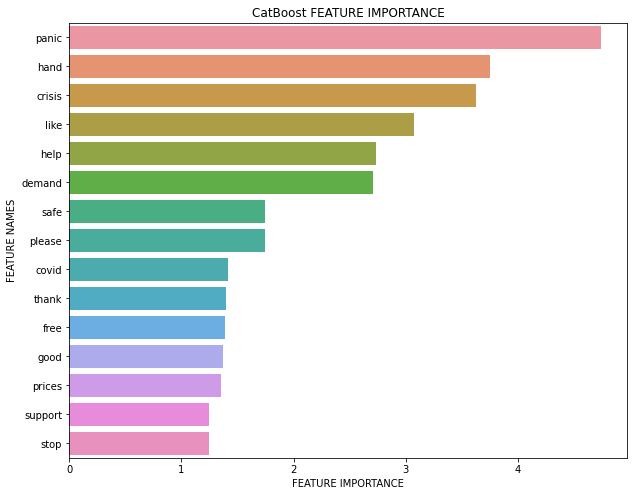

In [181]:
def plot_feature_importance(data,model_type):
  import matplotlib.pyplot as plt
  import seaborn as sns
  #Create arrays from feature importance and feature names  
  fi_df=data

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x='feature_importance', y='feature_names', data=fi_df[:15])#, order=fi_df[:20]['feature_importance'])
  # for p in splot.patches:
  #   splot.annotate(format(p.get_width(), '.1f'), 
  #                  ( p.get_width(), p.get_height()+p.get_x()), 
  #                  ha = 'center', va = 'center', 
  #                  xytext = (0, 9), 
  #                  textcoords = 'offset points')
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

  return fi_df[:20]


plot_feature_importance(data,"CatBoost ")

In [30]:
ngram=(1,1)
preproc = Pipeline([('tfidf',TfidfVectorizer(ngram_range = ngram,min_df = 5, max_df=0.6,lowercase = True)),('to_dense', DenseTransformer()),
                      ('selec',SelectKBest(k=1000,score_func=chi2))])
X_train1=preproc.fit_transform(X_train,y_train)
X_test1=preproc.transform(X_test)

X_df=pd.DataFrame(X_train1, columns=select_k_voca)
X_df.head()
lgb_clf=lgb.LGBMClassifier(random_state=0,silent=True, verbose_eval=50, max_depth= 50, min_data_in_leaf= 10, n_estimators= 500, num_leaves= 30, reg_alpha= 0.01)

lgb_clf.fit(X_df, y_train)
#print(clf.score(X_train1,y_train))                                                                                                                                                           
print('Model Training Accuracy w/o CV: %.3f' % lgb_clf.score(X_train1, y_train))
print('Model Test Accuracy w/o CV: %.3f' % lgb_clf.score(X_test1, y_test))


Model Training Accuracy w/o CV: 0.899
Model Test Accuracy w/o CV: 0.824


In [182]:
important_features_dict = {}
for x,i in enumerate(lgb_clf.feature_importances_):
    name=select_k_voca[x]
    important_features_dict[name]=i
data=pd.DataFrame(important_features_dict.items(), columns=['feature_names', 'feature_importance'])
data.sort_values(by=['feature_importance'], ascending=False,inplace=True)
data.tail()


,feature_names,feature_importance
801,ssa,0
707,remodels,0
800,spurs,0
786,slaps,0
331,exposes,0


,feature_names,feature_importance
620,panic,375
180,covid,368
192,crisis,348
528,like,329
663,prices,321
359,food,283
631,people,270
843,supermarket,261
412,hand,258
426,help,255


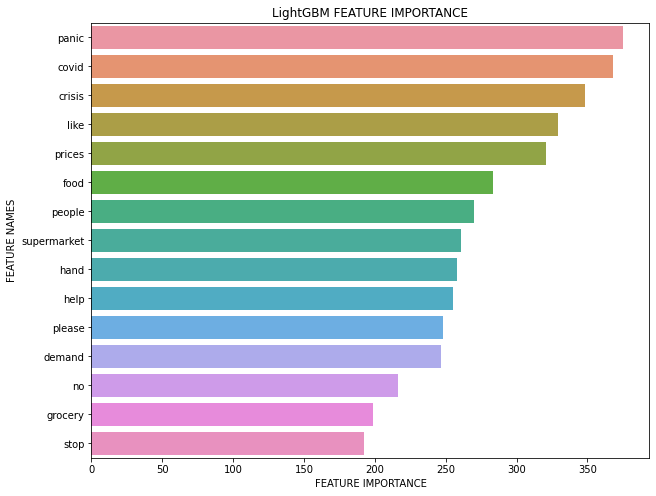

In [183]:

plot_feature_importance(data,"LightGBM ")

'my food stock one empty please panic there will be enough food for everyone take need stay calm stay safe'

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

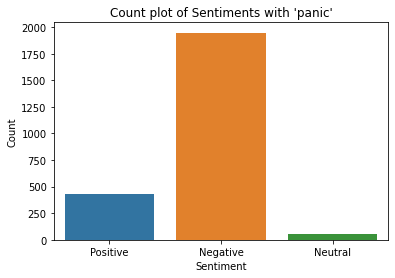

In [198]:
background=[i for i,x in enumerate(X_train1) if x[620]!=0]
y_back=y_train[background] #2436개
X_back=X_train[background] #2436개

y_df=pd.DataFrame(y_back)
y_df=y_df.replace({'Sentiment': {-1: 'Negative', 0:'Neutral',1: 'Positive'}})
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_df.Sentiment)
plt.title("Count plot of Sentiments with 'panic'")
plt.xlabel('Sentiment')
plt.ylabel('Count')

# 

In [207]:
print(X_back[6])
print(X_back[7])
print(X_back[29])

my food stock one empty please panic there will be enough food for everyone take need stay calm stay safe
me ready go supermarket outbreak not i paranoid food stock litteraly empty the serious thing please panic it causes shortage
this morning i tested positive covid i feel ok i symptoms far isolated since i found possible exposure virus stay home people pragmatic i keep updated i no panic


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0        donald j trump i worried economic fallout covi...
5        coronavirus australia woolworths give elderly ...
8        as news region first confirmed covid case came...
11       due covid retail store classroom atlanta open ...
12       for corona prevention stop buy things cash use...
                               ...                        
41105                what supermarket nearby getting covid
41112    definitely man i feel like fall need honor her...
41114    response complaint provided citing covid relat...
41117    well new used rift s going amazon rn although ...
41118    plus side covid saving money online shopping p...
Name: OriginalTweet, Length: 10415, dtype: object

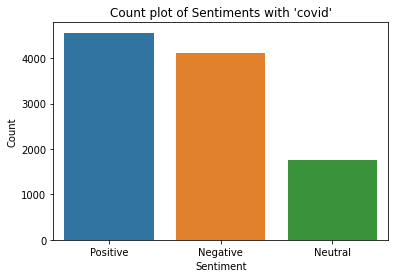

In [224]:
background=[i for i,x in enumerate(X_train1) if x[180]!=0]
y_back=y_train[background] #2436개
X_back=X_train[background] #2436개

y_df=pd.DataFrame(y_back)
y_df=y_df.replace({'Sentiment': {-1: 'Negative', 0:'Neutral',1: 'Positive'}})
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_df.Sentiment)
plt.title("Count plot of Sentiments with 'covid'")
plt.xlabel('Sentiment')
plt.ylabel('Count')


X_back

In [225]:
print(X_back[0])
print(X_back[5])
print(X_back[8])

donald j trump i worried economic fallout covid shelter place combination crashing oil prices i cut chase during holidays credit union program called
coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak
as news region first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports


spanish supermarket chains amp food distributors paying extra workers crisis plus bonuses
soon dwindling supplies unlawful panicky people breaking closed stores amp supermarkets raid normally crisis massive amp lockup
check folks so cal i like idea la habra supermarket offers special hours seniors amid covid crisis


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


3        spanish supermarket chains amp food distributo...
31       soon dwindling supplies unlawful panicky peopl...
82       check folks so cal i like idea la habra superm...
84       an open letter consumer debt holding organizat...
109      amid social distancing covid crisis starbucks ...
                               ...                        
40975    authorities far arrested individuals hoarding ...
40991    consumers globally u s america need higher gas...
41011    as come covid crisis consumer businesses need ...
41077    food banks equipped unemployment rate the fede...
41097    as physical stores close clothing retailers ho...
Name: OriginalTweet, Length: 1574, dtype: object

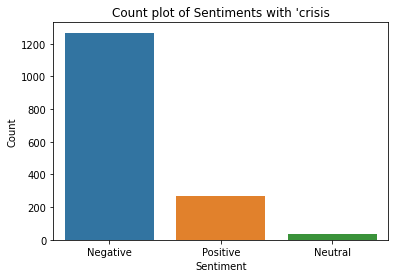

In [221]:
background=[i for i,x in enumerate(X_train1) if x[192]!=0]
y_back=y_train[background] #2436개
X_back=X_train[background] #2436개

y_df=pd.DataFrame(y_back)
y_df=y_df.replace({'Sentiment': {-1: 'Negative', 0:'Neutral',1: 'Positive'}})
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_df.Sentiment)
plt.title("Count plot of Sentiments with 'crisis")
plt.xlabel('Sentiment')
plt.ylabel('Count')


X_back

In [222]:
print(X_back[3])
print(X_back[31])
print(X_back[82])

spanish supermarket chains amp food distributors paying extra workers crisis plus bonuses
soon dwindling supplies unlawful panicky people breaking closed stores amp supermarkets raid normally crisis massive amp lockup
check folks so cal i like idea la habra supermarket offers special hours seniors amid covid crisis


2        joined growing list distilleries producing don...
8        as news region first confirmed covid case came...
91       the fact canned food toxic chemicals store bou...
153      mum actually mounted dispenser soap you wash h...
160      also people stocking soap hand sanitiser toile...
                               ...                        
41037    washing hands soap water best way keep coronav...
41069    check website we currently sale products get h...
41099    distilleries switched portions production alco...
41106    how exactly going open new york city still can...
41116          is wrong smell hand sanitizer starting turn
Name: OriginalTweet, Length: 1954, dtype: object

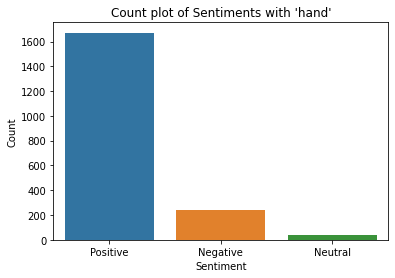

In [43]:
background=[i for i,x in enumerate(X_train1) if x[412]!=0]
y_back=y_train[background] #2436개
X_back=X_train[background] #2436개

y_df=pd.DataFrame(y_back)
y_df=y_df.replace({'Sentiment': {-1: 'Negative', 0:'Neutral',1: 'Positive'}})
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_df.Sentiment)
plt.title("Count plot of Sentiments with 'hand'")
plt.xlabel('Sentiment')
plt.ylabel('Count')


X_back

In [45]:
print(X_back[2])
print(X_back[91])
print(X_back[153])
print(X_back[160])
print(X_back[41037])

joined growing list distilleries producing donating hand sanitizer ease shortage we thankful generous donations gallon drums sanitizer three two
the fact canned food toxic chemicals store bought hand sanitizers stock yet fresh fruit vegetables herbs fully stocked shows humans idea immune system works
mum actually mounted dispenser soap you wash hand enter supermarket no chance covid
also people stocking soap hand sanitiser toilet roll leaving shelves empty rest us you realise stop spread people need able wash hands
washing hands soap water best way keep coronavirus bay if soap water readily available use alcohol based hand sanitizer contains least alcohol


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


41                now i go supermarket like without judged
65       so feeling like ethical still stuff like order...
72       it kind like saying word makes sound like word...
81       as retailers close physical stores curtail hou...
82       check folks so cal i like idea la habra superm...
                               ...                        
41012    i think buying habits temporary changed future...
41015    china amp us share s p outcomes china losing w...
41040    sneezed grocery store today the power threat p...
41111    i never would situation amp world going superm...
41112    definitely man i feel like fall need honor her...
Name: OriginalTweet, Length: 2254, dtype: object

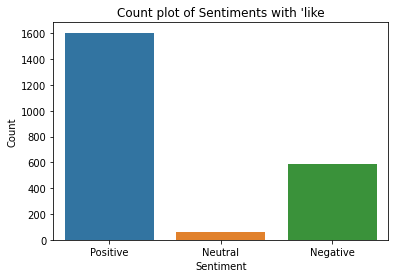

In [229]:
background=[i for i,x in enumerate(X_train1) if x[528]!=0]
y_back=y_train[background] #2436개
X_back=X_train[background] #2436개

y_df=pd.DataFrame(y_back)
y_df=y_df.replace({'Sentiment': {-1: 'Negative', 0:'Neutral',1: 'Positive'}})
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(y_df.Sentiment)
plt.title("Count plot of Sentiments with 'like'")
plt.xlabel('Sentiment')
plt.ylabel('Count')


X_back

In [230]:
print(X_back[41])
print(X_back[65])
print(X_back[72])

now i go supermarket like without judged
so feeling like ethical still stuff like order deliveries food online shopping etc ship isolation care packages loved ones etc
it kind like saying word makes sound like word anymore for many people think covid news bs making go stores panic buy food basic necessities nothing left


In [ ]:
#########PDP@#####################
#class 0:negative/ 1: neutral

In [34]:
pdp_dist

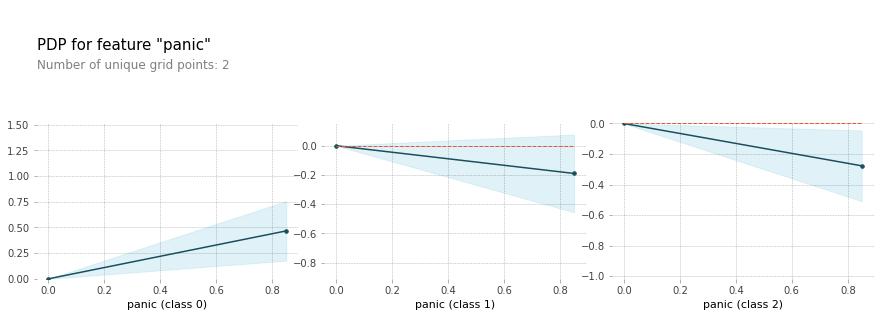

In [36]:

pdp_dist = pdp.pdp_isolate(model=lgb_clf, dataset=X_df
                           , model_features=select_k_voca
                           , feature='panic')
pdp.pdp_plot(pdp_dist, 'panic', ncols=3);

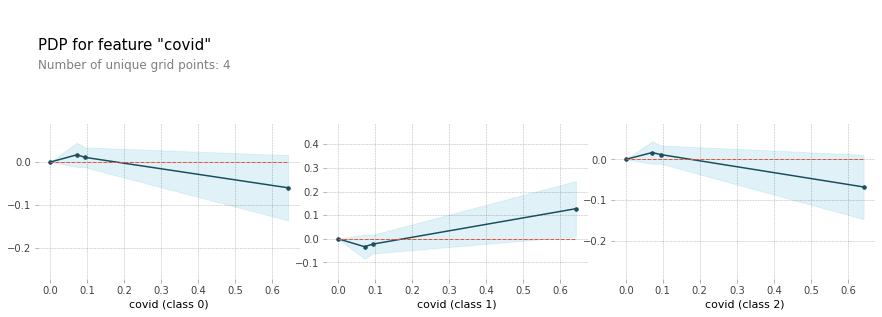

In [37]:

pdp_dist = pdp.pdp_isolate(model=lgb_clf, dataset=X_df
                           , model_features=select_k_voca
                           , feature='covid')
pdp.pdp_plot(pdp_dist, 'covid', ncols=3);

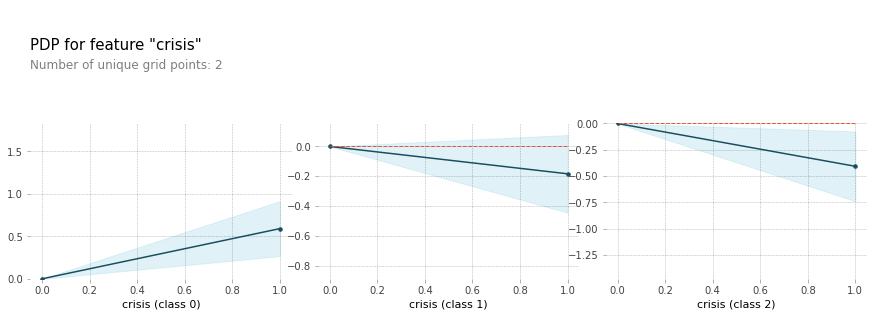

In [38]:

pdp_dist = pdp.pdp_isolate(model=lgb_clf, dataset=X_df
                           , model_features=select_k_voca
                           , feature='crisis')
pdp.pdp_plot(pdp_dist, 'crisis', ncols=3);

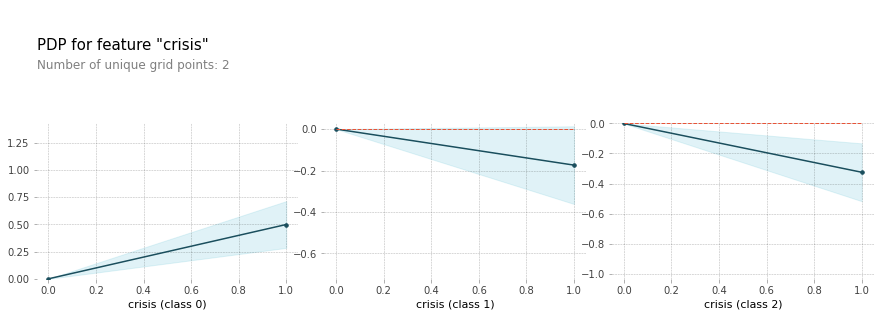

In [39]:
#CAT
pdp_dist = pdp.pdp_isolate(model=clf, dataset=X_df
                           , model_features=select_k_voca
                           , feature='crisis')
pdp.pdp_plot(pdp_dist, 'crisis', ncols=3);

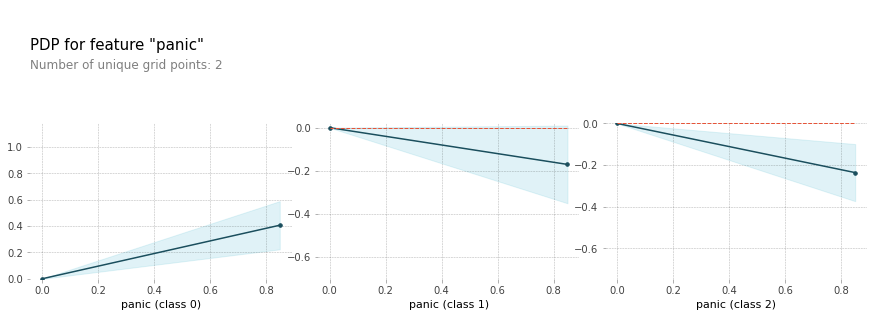

In [40]:

pdp_dist = pdp.pdp_isolate(model=clf, dataset=X_df
                           , model_features=select_k_voca
                           , feature='panic')
pdp.pdp_plot(pdp_dist, 'panic', ncols=3);

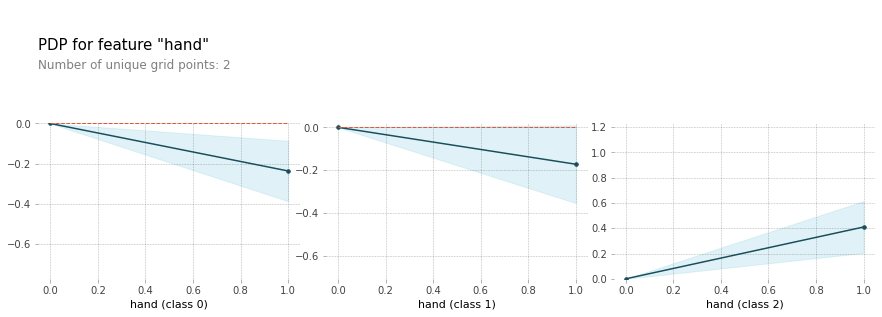

In [41]:

pdp_dist = pdp.pdp_isolate(model=clf, dataset=X_df
                           , model_features=select_k_voca
                           , feature='hand')
pdp.pdp_plot(pdp_dist, 'hand', ncols=3);